# 集成学习 XGBoost

包含Boosting三要素：
- 损失函数
- 弱评估器
- 综合集成过程

**树模型的学习能力和过拟合风险之间的平衡，就是预测精确性与模型复杂的之间的平衡，也是经验风险与结构风险之间的平衡。**

XGBoost 精确度与复杂度的平衡考虑：
1. XGBoost为损失函数加入结构风险项，构成目标函数
2. 使用全新不纯度衡量指标，将复杂度纳入分枝规则

**极大程度地降低模型复杂度，提升模型运行效率，将算法武装成更加适合于大数据的算法**

XGBoost优化技巧：
1. 使用估计贪婪算法、平行学习、分位数草图算法等方法构建了适用于大数据的全新建树流程
2. 使用感知缓存访问技术与核外计算技术，提升算法在硬件上的运算性能
3. 引入Dropout技术，为整体建树流程增加更多随机性，让算法适应更大数据

XGBoost保留了部分与梯度提升树类似的属性，包括：
- 弱评估器的输出类型与集成算法输出类型不一致
- 拟合负梯度，且当损失函数是0.5倍MSE时，拟合残差
- 抽样思想

In [1]:
# pip install xgboost -i https://pypi.tuna.tsinghua.edu.cn/simple
# pip install --upgrade xgboost
import xgboost as xgb
xgb.__version__

'1.6.1'

# XGBoost的实现
- sklearnAPI
- 原生

## sklearnAPI实现

In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate,KFold
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

data = pd.read_csv(r"/Users/feishuoren/Projects/machine_learning/datasets/HousePrice/train_encode.csv",index_col=0)
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [4]:
# 回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [5]:
X.shape

(1460, 80)

In [6]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [7]:
# sklearn 普通训练代码三步走：实例化，fit,score
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

xgb_sk = XGBRegressor(random_state=1412) # 实例化模型
xgb_sk.fit(Xtrain,Ytrain)
xgb_sk.score(Xtest,Ytest) # 默认指标R2

0.8707175563742298

In [8]:
# sklearn 交叉验证三步走：实例化，交叉验证，对结果求平均

xgb_sk = XGBRegressor(random_state=1412)

In [9]:
# 定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                              ,scoring = "neg_root_mean_squared_error" # 负根均方误差
                              ,return_train_score = True
                              ,verbose = True
                              ,n_jobs=-1
                              )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.1s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


In [10]:
result_xgb_sk

{'fit_time': array([2.27707911, 2.27484918, 2.29944491, 2.31527305, 2.30683804]),
 'score_time': array([0.01648688, 0.01526093, 0.01719975, 0.01016808, 0.01496506]),
 'test_score': array([-25398.06063039, -42892.11176772, -26426.91326917, -20676.41934632,
        -33375.56869975]),
 'train_score': array([ -903.74997856, -1106.45801425,  -997.3799282 ,  -818.69215194,
         -877.57892862])}

In [11]:
def RMSE(result,name):
    return abs(result[name].mean())

In [12]:
RMSE(result_xgb_sk,"train_score")

940.7718003131752

In [13]:
RMSE(result_xgb_sk,"test_score")

29753.814742669765

### 参数调整
改善过拟合情况，提升分数
- 加入max_depth

In [14]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412)

In [15]:
result_xgb_sk = cross_validate(xgb_sk,X,y,cv=cv
                              ,scoring = "neg_root_mean_squared_error" # 负根均方误差
                              ,return_train_score = True
                              ,verbose = True
                              ,n_jobs = -1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


In [16]:
RMSE(result_xgb_sk,"train_score")

2362.6596931022264

In [17]:
RMSE(result_xgb_sk,"test_score")

28623.2199609373

sklearn训练完毕后，要查看训练后的模型，可以调用sklearn中部分常见属性。

 - feature_importances_
 - get_booster()
 - get_num_boosting_rounds()
 - get_params

In [18]:
xgb_sk = XGBRegressor(max_depth=5,random_state=1412).fit(X,y)

In [19]:
# 查看特征重要性
xgb_sk.feature_importances_

array([2.75380560e-04, 3.31971998e-04, 1.00358156e-02, 1.05883693e-03,
       3.16664134e-03, 0.00000000e+00, 1.98506648e-04, 2.89293937e-03,
       1.25273280e-02, 0.00000000e+00, 5.93377743e-04, 1.02778999e-02,
       2.30982271e-03, 1.63636741e-03, 2.90878420e-03, 2.35304120e-03,
       6.21278654e-04, 4.83804524e-01, 3.57081974e-03, 5.26868505e-03,
       5.39273489e-03, 1.19193934e-03, 6.73988950e-04, 8.58596177e-04,
       7.24220707e-04, 6.31435658e-04, 6.40772341e-04, 1.79228242e-02,
       1.88877675e-04, 5.03550633e-04, 1.56989340e-02, 2.03612563e-03,
       2.47432292e-03, 1.01661379e-03, 8.10322072e-03, 2.90135911e-04,
       5.88890282e-04, 7.41500990e-04, 1.55724427e-02, 4.79830429e-04,
       3.00964224e-04, 3.08048874e-02, 1.71841952e-04, 1.05094137e-02,
       7.64262909e-03, 5.08715457e-04, 3.02572548e-02, 2.92710634e-03,
       3.74272262e-04, 3.38621549e-02, 1.68845232e-03, 5.42165304e-04,
       3.92313190e-02, 2.88939234e-02, 3.41931777e-03, 3.12080747e-03,
      

In [20]:
# 调出其中一棵树，不过无法展示出树的细节，只能调出建树的Booster对象
xgb_sk.get_booster()[0]

一棵树都是一个单独的Booster提升树，Booster就相当于sklearn中DecisionTreeRegressor，只不过是使用XGBoost独有的建树规则进行计算

In [21]:
# 查看一共建立了多少棵树，相当于是 n_estimators 的取值
xgb_sk.get_num_boosting_rounds()

100

In [22]:
# 获取每一个参数的取值
xgb_sk.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 5,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1412,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## 原生代码实现

必须使用XGBoost自定义的数据结构 DMatrix

In [23]:
import xgboost as xgb

In [24]:
X.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,半开放式门廊面积,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0


In [25]:
data_xgb = xgb.DMatrix(X,y)
data_xgb

In [26]:
type(data_xgb)

xgboost.core.DMatrix

In [27]:
# DMatrix 数据，无法使用索引或者循环查看内部内容，难以调用或者修改
data_xgb[0]

TypeError: 'DMatrix' object is not subscriptable

In [28]:
# 提前准备好训练集、测试集，再转换为DMatrix

In [29]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [30]:
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)

- 定义需要输出的参数，直接进行训练

**除了建树棵树、提前停止这两个关键元素，其他参数基本都被设置在params中**

In [31]:
params = {"max_depth":5,"seed":1412}

In [32]:
reg = xgb.train(params,data_xgb,num_boost_round=100)

**XGBoost 默认执行回归算法**

In [33]:
y_pred = reg.predict(data_xgb)
y_pred

array([204427.03, 181824.06, 220590.2 , ..., 266362.62, 141301.05,
       149763.83], dtype=float32)

**对于回归类算法，xgboost默认评估指标是RMSE**

- 一半评估方式

In [34]:
from sklearn.metrics import mean_squared_error as MSE

MSE(y,y_pred,squared=False) # RMSE

3296.8467469477046

- 使用交叉验证进行训练

In [35]:
params = {"max_depth":5,"seed":1412}
result = xgb.cv(params,data_xgb,num_boost_round=100
               ,nfold=5 # 补充交叉验证中所需的参数，5折交叉验证
               ,seed=1412 # 交叉验证的随机数种子，params中的是管理 boosting 过程的随机数种子
               )

In [36]:
result # dataframe

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,141522.725236,1318.895187,141941.480849,6432.945779
1,102183.565359,1053.671177,103857.755141,5778.063359
2,74524.577931,728.021132,77554.022895,5732.161793
3,55214.230823,465.431763,59894.983828,6121.922664
4,41754.466105,345.497245,47824.115981,5734.478273
...,...,...,...,...
95,2513.421912,206.433112,28623.112097,7513.195378
96,2476.676623,201.605960,28624.676691,7517.552722
97,2440.533444,203.698010,28620.467372,7523.207087
98,2405.017552,210.983154,28619.228293,7525.503231


In [37]:
# 绘图
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'xgboost 5fold cv')

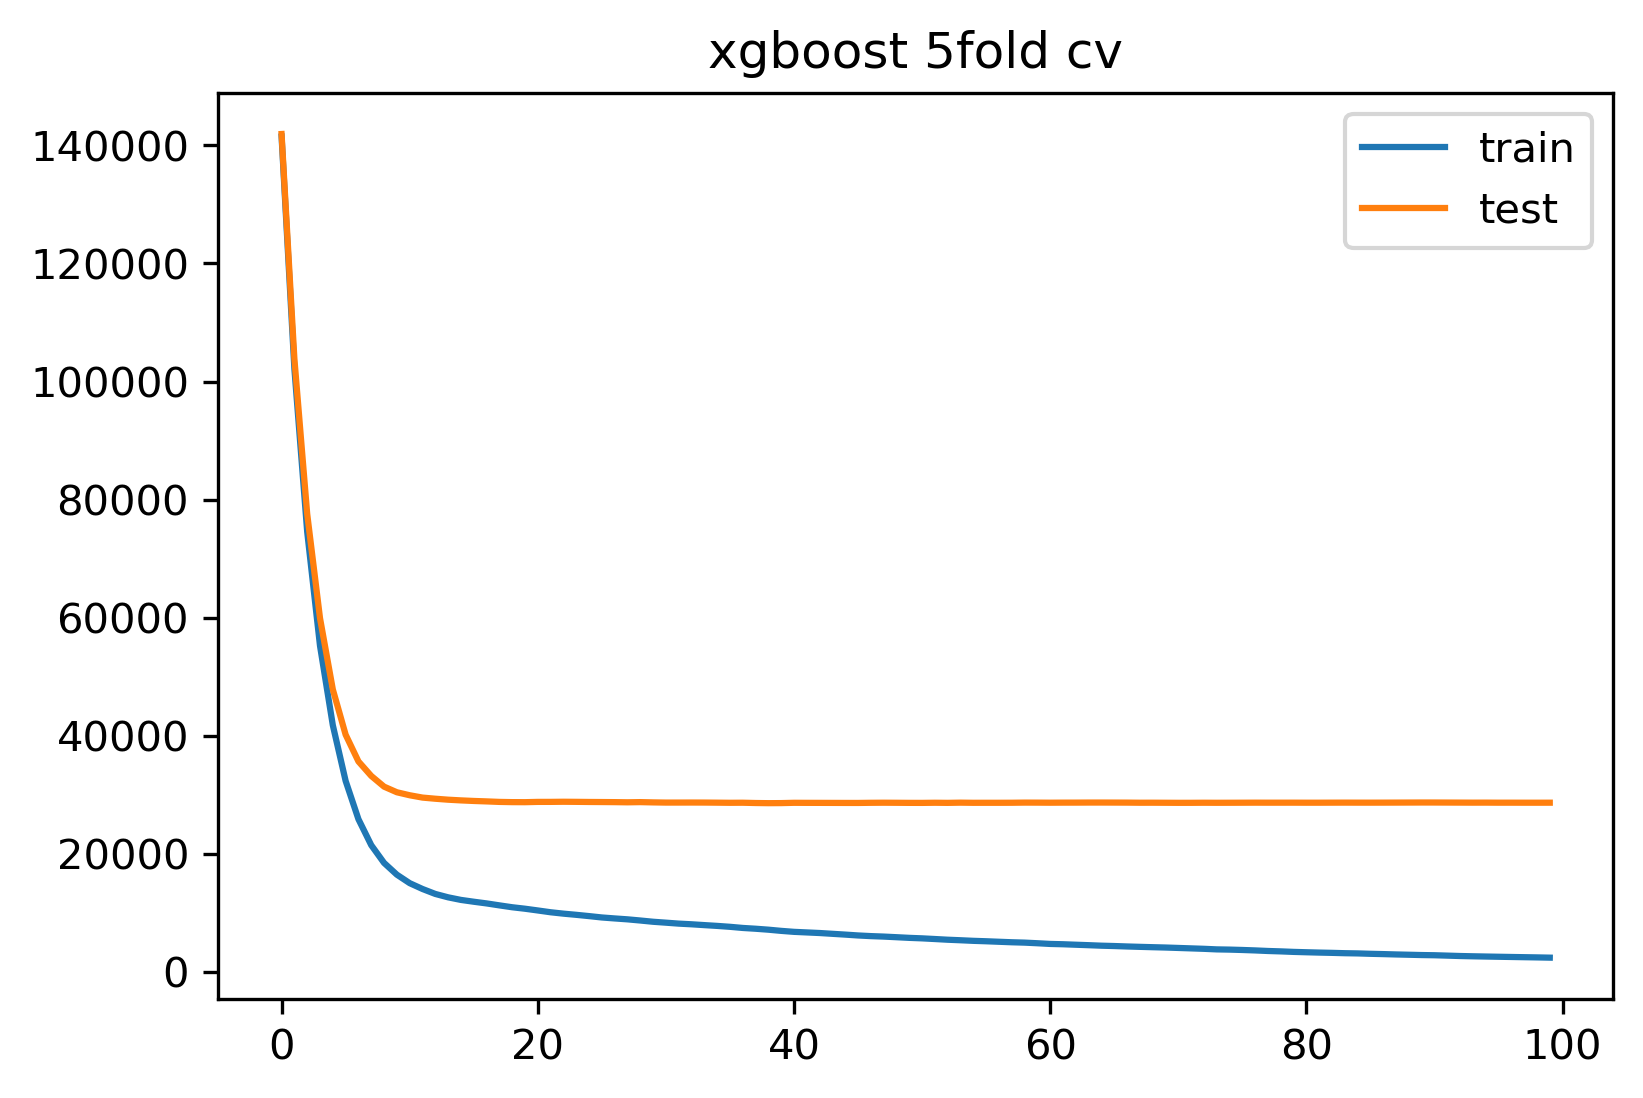

In [38]:
plt.figure(dpi=300)
plt.plot(result["train-rmse-mean"])
plt.plot(result["test-rmse-mean"])
plt.legend(["train","test"])
plt.title("xgboost 5fold cv")